<a href="https://colab.research.google.com/github/yudhistirank/EcoSense-C242-PS114/blob/ML/EcoSense_Waste_Clasification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EcoSense - Waste Clasification
Waste Clasification using CNN

## Prerequisite
https://pypi.org/project/gdown

In [1]:
!pip install gdown -q

## Import neccessary library

In [2]:
import tensorflow as tf
print(tf.__version__)

2.17.1


In [3]:
import tensorflow.keras as keras
print(keras.__version__)

3.5.0


In [4]:
import numpy as np
import random
import os
import gdown
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Download Dataset

Link Dataset: https://drive.google.com/file/d/16Q-dlc3QzQuRzu9KBsnYB8nyfZNBH7eU/view?usp=drivesdk

In [5]:
url = "https://drive.google.com/uc?id=1G2E1AzDKsYElVZvrSi2O4FfPmDNcv5cC"

dataset_path = "DATASET.zip"
path_folder = "/content/Dataset_Klasifikasi_Sampah"

print("Downloading dataset...")
gdown.download(url, output=dataset_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1G2E1AzDKsYElVZvrSi2O4FfPmDNcv5cC
From (redirected): https://drive.google.com/uc?id=1G2E1AzDKsYElVZvrSi2O4FfPmDNcv5cC&confirm=t&uuid=0d0ffd27-400f-4c43-a465-ef4d99187eea
To: /content/DATASET.zip
100%|██████████| 225M/225M [00:02<00:00, 98.5MB/s]


'DATASET.zip'

In [6]:
print("Extracting dataset...")
if not os.path.exists(path_folder):
    os.makedirs(path_folder)

with zipfile.ZipFile(dataset_path, 'r') as zip_extractor:
    zip_extractor.extractall(path_folder)

print("Dataset successfully extracted!")

Extracting dataset...
Dataset successfully extracted!


In [7]:
train_dir = os.path.join(path_folder, 'TRAIN')
test_dir = os.path.join(path_folder, 'TEST')

## Exploratory Data Analysis

In [8]:
train_dir_O = os.listdir(os.path.join(train_dir, 'O'))
train_dir_R = os.listdir(os.path.join(train_dir, 'R'))
test_dir_O = os.listdir(os.path.join(test_dir, 'O'))
test_dir_R = os.listdir(os.path.join(test_dir, 'R'))

print(f'Total train O images: {len(train_dir_O)}')
print(f'Total train R images: {len(train_dir_R)}')
print(f'Total test O images: {len(test_dir_O)}')
print(f'Total test R images: {len(test_dir_R)}')

Total train O images: 12575
Total train R images: 9999
Total test O images: 1411
Total test R images: 1112


Sample images from class 'O'


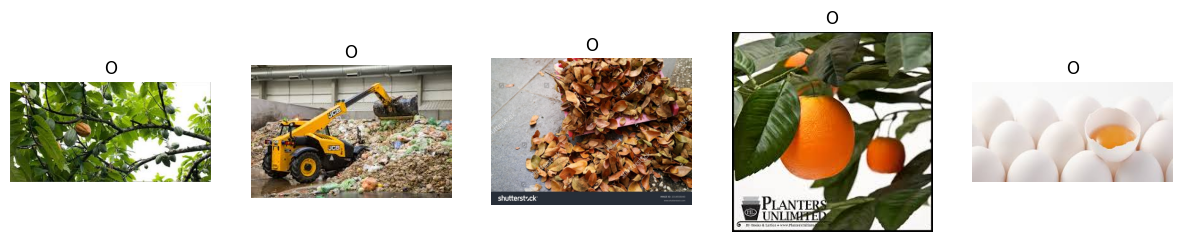

Sample images from class 'R'


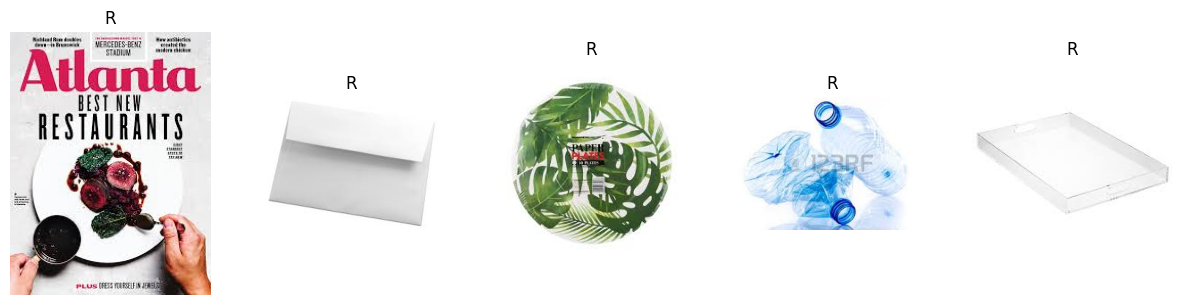

In [9]:
def visualize_samples(folder_path, class_name, num_samples=5):
    class_folder = os.path.join(folder_path, class_name)
    sample_files = random.sample(os.listdir(class_folder), num_samples)
    plt.figure(figsize=(15, 5))
    for i, file_name in enumerate(sample_files):
        img_path = os.path.join(class_folder, file_name)
        img = Image.open(img_path)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.show()

print("Sample images from class 'O'")
visualize_samples(train_dir, 'O')

print("Sample images from class 'R'")
visualize_samples(train_dir, 'R')

## Model Preparation

In [10]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(150, 150),
    batch_size=20,
    label_mode='categorical')

Found 22574 files belonging to 2 classes.


In [11]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(150, 150),
    batch_size=20,
    label_mode='categorical')

Found 2523 files belonging to 2 classes.


In [12]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## Building Model

In [13]:
def build_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(150, 150, 3)),
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [14]:
model = build_model()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 18, 18, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 3,652,738 (13.93 MB)

 Trainable params: 3,650,818 (13.93 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

## Model Training

In [16]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 88s 64ms/step - accuracy: 0.7769 - loss: 4.8427 - val_accuracy: 0.8962 - val_loss: 2.5522
Epoch 2/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 115s 52ms/step - accuracy: 0.8431 - loss: 2.2558 - val_accuracy: 0.8819 - val_loss: 1.2672
Epoch 3/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 58s 52ms/step - accuracy: 0.8578 - loss: 1.1183 - val_accuracy: 0.9172 - val_loss: 0.5672
Epoch 4/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 58s 51ms/step - accuracy: 0.8722 - loss: 0.5862 - val_accuracy: 0.9148 - val_loss: 0.3530
Epoch 5/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 83s 52ms/step - accuracy: 0.8789 - loss: 0.3928 - val_accuracy: 0.9306 - val_loss: 0.2595
Epoch 6/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 59s 52ms/step - accuracy: 0.8850 - loss: 0.3311 - val_accuracy: 0.9251 - val_loss: 0.2607
Epoch 7/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 59s 52ms/step - accuracy: 0.8975 - loss: 0.3027 - val_accuracy: 0.9275 - val_loss: 0.2391
Epoch 8/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 59s 52ms/step - accuracy: 0.9051 

## Model Evaluation

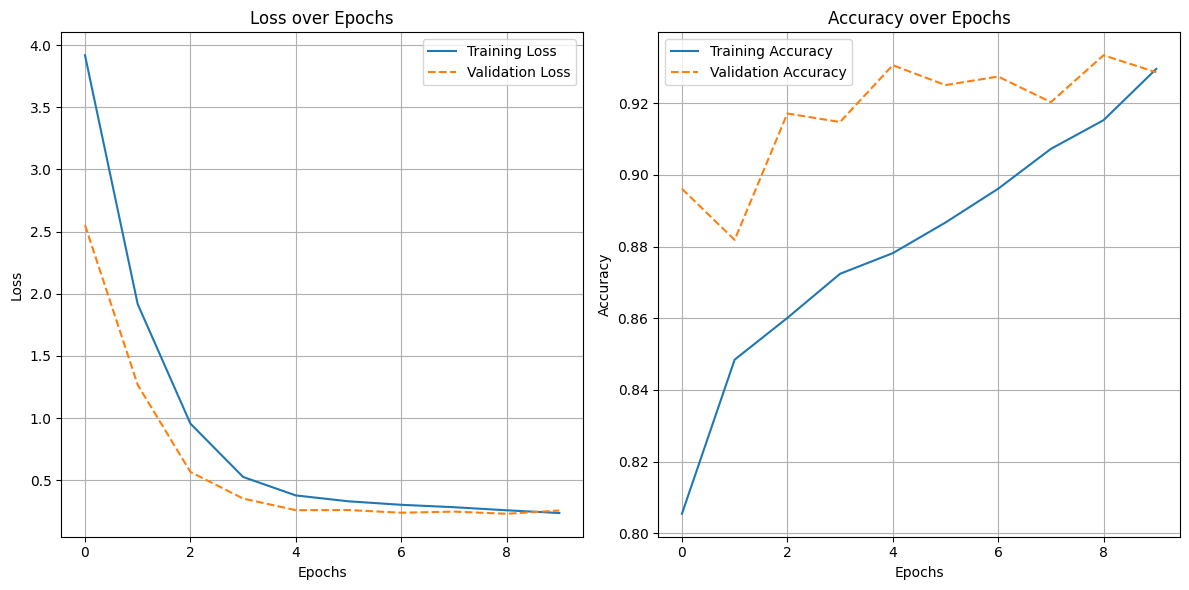

In [17]:
# Loss development plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy development plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show graph
plt.tight_layout()
plt.show()

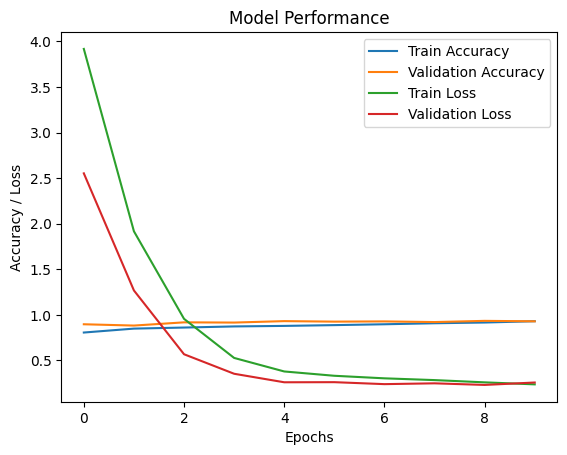

In [18]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.show()

In [19]:
loss, accuracy = model.evaluate(validation_dataset)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9332 - loss: 0.2416
Validation Loss: 0.25696879625320435
Validation Accuracy: 0.9286563396453857


## Save Model

In [20]:
model.save("klasifikasi_sampah1.h5")
print("Model telah disimpan ke file ecosense_model.h5")

Model telah disimpan ke file ecosense_model.h5


In [21]:
model.save("klasifikasi_sampah1.keras")

In [22]:
h5_model_path = 'klasifikasi_sampah1.keras'
model = tf.keras.models.load_model(h5_model_path)

# Create a converter from a model
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Convert to TFLite format
tflite_model = converter.convert()

# Save the TFLite model to a file
tflite_model_path = 'model.tflite'
with open(tflite_model_path, 'wb') as f:
       f.write(tflite_model)

print(f"Model berhasil dikonversi dan disimpan sebagai {tflite_model_path}")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 22 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Saved artifact at '/tmp/tmpftr5uxd4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  139228673161728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139228661163536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139228661374416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139228661380576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139228660752880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139228660753232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139228661382336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139228503919072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139228504311936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139228504311056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139228504310000